# simple Exponential Smoothing
- Y_dach_t+1 = alpha*y_t + (1-apha)y_dach_t    t =0, 1, ....

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
df_train  =  pd.read_csv('train.csv', parse_dates=['date'])
df_oil = pd.read_csv('../oil.csv', parse_dates=['date'])
df_sample_submission = pd.read_csv('sample_submission.csv')
df_stores = pd.read_csv('stores.csv')
df_test = pd.read_csv('test.csv', parse_dates=['date'])
df_transaction = pd.read_csv('transactions.csv', parse_dates=['date'])
df_holidays_events = pd.read_csv('holidays_events.csv', parse_dates=['date'])

In [38]:
#data = df_train.merge(df_stores, on=['store_nbr'], how='left')
data = df_train.copy()
data = data.groupby(['id', 'date', 'store_nbr','family'])['sales'].sum().reset_index()
data.shape

(3000888, 5)

In [39]:
def mase(y_true, y_pred, y_train) -> float:
    naive_forecast = y_train[:-1]  # naive forecast: previous value
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mase = mean_absolute_error(y_true, y_pred) / mae_naive
    return mase

In [5]:
def eval_model(y_true, y_pred) :
    # Calculate the mean squared logarithm error
    print(f"mean squared logarithm error: {mean_squared_log_error(y_true, y_pred)}")
    print(f"R Sccore model score: {r2_score(y_true, y_pred)}")
    print(f"mean absolute error: {mean_absolute_error(y_true, y_pred)}")
    print(f"mean squared error: {mean_squared_error(y_true, y_pred)}")
    print(f"mase: {mase(y_true, y_pred, y_true)}")

In [51]:
def plot_func(pred_data, t_data, c: int, f: str, title : str) -> None:
    data_c_f = t_data[(t_data['store_nbr'] == c) & (t_data['family'] == f)]
    forecasts = pred_data[(pred_data['store_nbr'] == c) & (pred_data['family'] == f)]
    train_split = data_c_f[:-int(len(data_c_f)*0.2)]
    train_split = train_split[train_split['date'].isin(df_holidays_events['date'])]
    forecasts = forecasts[forecasts['date'].isin(df_holidays_events['date'])]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_split['date'], y=train_split['sales'], name='Train'))
    fig.add_trace(go.Scatter(x=forecasts['date'], y=forecasts['sales'], name='Test'))
    fig.add_trace(go.Scatter(x=forecasts['date'], y=forecasts['sales_forecast'], name='Forecast'))
    fig.update_layout(template='simple_white', font=dict(size=10), title_text=title, xaxis_title='date',yaxis_title='Sales', width=750)

    eval_model(forecasts['sales'], forecasts['sales_forecast'])

    return fig.show()

In [41]:
def forecast(args) -> pd.DataFrame:

    train_cluster_family , test_cluster_family , arima = args
    if arima:
        model = ARIMA(train_cluster_family['sales'], order=(14,1,14)).fit()
    else:
        model = SimpleExpSmoothing(train_cluster_family['sales']).fit(optimized=True)

    prediction = model.forecast(len(test_cluster_family))

    test_cluster_family['sales_forecast'] = prediction
    test_cluster_family.dropna(inplace=True, axis=0)
    forecast_results = test_cluster_family.copy().reset_index(drop=True)

    return forecast_results

In [46]:
def train_model(args) -> pd.DataFrame:
    c, f , date , y , arima = args

    group = []
    for cluster in data[c].unique():
        for family in data[f].unique():
            data_cluster_family = data[(data[c] == cluster) & (data[f] == family)].reset_index(drop=True)
            range_date = pd.date_range(start=data_cluster_family[date].min(), end=data_cluster_family[date].max(), freq='D')
            data_cluster_family  = pd.merge(pd.DataFrame({date: range_date}), data_cluster_family, on=[date], how='left')
            data_cluster_family[y].fillna(0, inplace=True)
            train = data_cluster_family[:-int(len(data_cluster_family)*0.2)]
            test = data_cluster_family[-int(len(data_cluster_family)*0.2):]
            group.append(forecast((train,test,arima)))

    # Combine the results
    final_predictions = pd.concat(group, ignore_index=True)

    # Ensure predictions are not negative
    final_predictions['sales'] = np.maximum(0, final_predictions['sales'])

    return final_predictions


In [47]:

final_predictions = train_model(('store_nbr', 'family' , 'date' , 'sales', False))
final_predictions.to_csv('results_forecasting.csv', index=False)

In [54]:
f_data = pd.read_csv('../results/results_forecasting.csv', parse_dates=['date'])
store_nbr  = 3
family = "BEAUTY"
plot_func(f_data, data , store_nbr, family, f"Forecasting for product family {family} in Store  {store_nbr}")

mean squared logarithm error: 0.2812748711694583
R Sccore model score: -0.003799784109187465
mean absolute error: 4.966344112408586
mean squared error: 40.064420289451725
mase: 0.824799198880578


In [48]:
print("Overall performance:")
eval_model(f_data['sales'], f_data['sales_forecast'])

Overall performance:
mean squared logarithm error: 0.9316731385078765
R Sccore model score: 0.8966927839716867
mean absolute error: 359.73363899680345
mean squared error: 1900395.5565071343
mase: 0.9437389984634187


### Arima model

In [67]:
# Import packages
import plotly.express as px
import pandas as pd

# Read in the data
def plot_sales_volumes(df: pd.DataFrame,
                           y: str, c: int, fam: str ) -> None:
    """General function to plot the sales data based on cluster and family."""
    df['month'] = df['date'].dt.to_period('M')

    # Grouper par mois sans perdre les données originales
    df_filtered = df[(df['store_nbr'] == c)&(df['family'] == fam)]
    df_filtered = df_filtered.groupby(['month'])['sales'].sum().reset_index()
    df_filtered['month'] = df_filtered['month'].astype(str)
    fig = px.line(df_filtered, x='month', y=y)
    fig.update_layout(template="simple_white", font=dict(size=15), title_text=f'Sales for family product {fam} in store {c}', width=850, title_x=0.5)

    return fig.show()


# Plot the airline passenger data
plot_sales_volumes(df=data, y='sales', c=2, fam='BEAUTY')

In [31]:
def filter_data(df: pd.DataFrame,  c: int, fam: str) -> pd.DataFrame:
    return df[(df['cluster'] == c) & (df['family'] == fam)]


In [58]:
import pandas as pd

# Exemple de DataFrame
df = pd.DataFrame({
    'date_column': pd.to_datetime(['2023-01-15', '2023-01-20', '2023-02-10', '2023-02-28', '2023-03-05']),
    'sales': [100, 200, 150, 300, 250]
})

# Ajouter une colonne "month"
df['month'] = df['date_column'].dt.to_period('M')

# Grouper par mois sans perdre les données originales
df = df.groupby(['month'])['sales'].sum().reset_index()

print(df)


     month  sales
0  2023-01    300
1  2023-02    450
2  2023-03    250


In [82]:
# Import packages
from scipy.stats import boxcox
df_filtered = data.query('sales > 0')
# Make the target variance stationary
df_filtered['sales_Boxcox'], lam = boxcox(df_filtered['sales'])
# Plot the box-cox passenger data
plot_sales_volumes(df=df_filtered, y='sales_Boxcox', c=5, fam='BEAUTY')

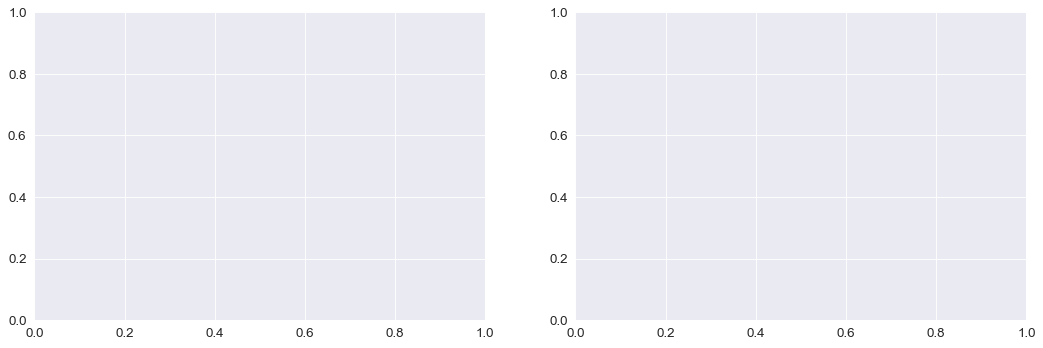

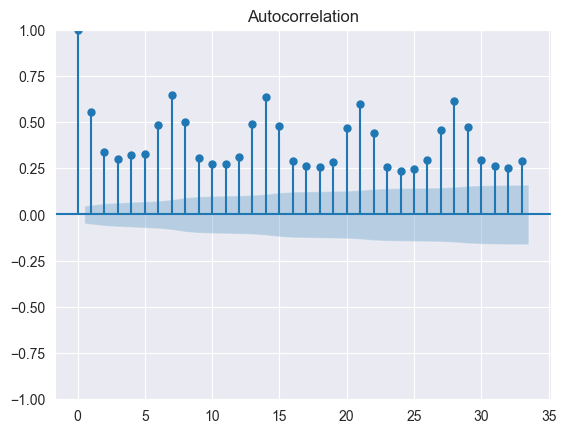

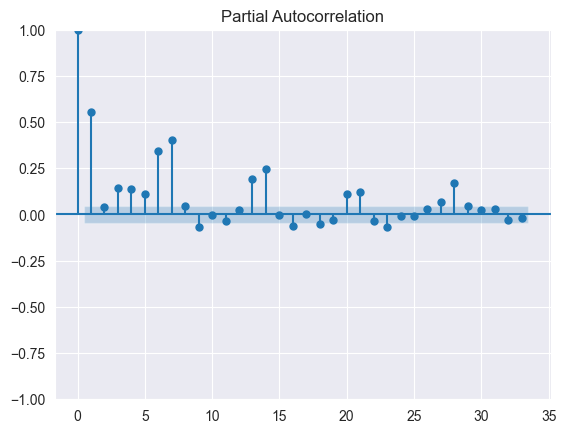

In [12]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
#data["Passenger_diff"] = data["Passengers_Boxcox"].diff()
#data.dropna(inplace=True)
df_filtered = filter_data(df=data, c=8, fam='BEAUTY')
df_filtered["sales_diff"] = data["sales"].diff()
df_filtered.dropna(inplace=True, axis=0)
# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(df_filtered['sales'])
plot_pacf(df_filtered['sales'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [16]:
# Sélectionner le magasin et la famille
store_nbr = 8
family = 'PRODUCE'

# Filtrer les données
filtered_df = df_train[(df_train['store_nbr'] == store_nbr) & (df_train['family'] == family)]

# Extraire la colonne 'sales' pour le test ADF
sales_data = filtered_df['sales']
result = adfuller(sales_data)

print('Statistique ADF :', result[0])
print('Valeur p :', result[1])
print('Valeurs critiques :', result[4])

Statistique ADF : -3.287944093018063
Valeur p : 0.015426050146170982
Valeurs critiques : {'1%': np.float64(-3.4342906911169404), '5%': np.float64(-2.8632805908715726), '10%': np.float64(-2.5676966486957706)}


In [34]:
# Import packages
from scipy.special import inv_boxcox
train_model(('cluster', 'family' , 'date' , 'sales', True))
final_predictions.to_csv('arima_results_forecasting.csv', index=False)

In [ ]:
arima_f_data = pd.read_csv('../results/arima_results_forecasting.csv', parse_dates=['date'])
cluster = 9
family = "BEAUTY"
plot_func(f_data, data , cluster, family, f" ARIMA Forecasting for product family {family} in cluster {cluster}")

In [ ]:
print("Overall performance for ARIMA Model:")
eval_model(arima_f_data['sales'], arima_f_data['sales_forecast'])